<a href="https://colab.research.google.com/github/hws2002/MachineLearning_PytorchNScikitLearn/blob/master/Chapter11/Chapter11_2_MNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

# 11.2 손글씨 숫자 분류
실제 신경망을 한번 만들어 보자

# 11.2.1 MNIST 데이터셋 구하기
https://www.kaggle.com/datasets/hojjatk/mnist-dataset 에 공개되어 있으며 다음 네 부분으로 구성되어 있음.  

1. 훈련 데이터셋 이미지
2. 훈련 데이터셋 레이블
3. 테스트 데이터셋 이미지
4. 테스트 데이터셋 레이블


In [2]:
# 위에서 언급한 데이터셋 파일을 다운로드하여 직접 넘파이 배열로 변환하는 대신, 사이킷런의 fetch_openml 함수를 사용하여 MNIST 데이텃셍르 편리하게 로드할수 있음.
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True) # MNIST 데이터셋을 pandas DataFrame 및 Series 객체로 다운로드함
# ! 1.0 이전 버전의 사이킷런을 사용하는 경우, fetch_openml이 넘파이 배열을 다운로드하므로 .values속성을 사용하지 않아도 됨
X = X.values
y = y.astype(int).values

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# MNIST의 픽셀 값을 -1에서 1범위로 정규화하자
# 이미지 픽셀로 작업할 때는 중앙을 0으로 맞추고 [-1,1] 범위로 스케일링 하는 것이 일반적이며 실제로도 잘 작동함
X = ((X/225.) - .5) * 2

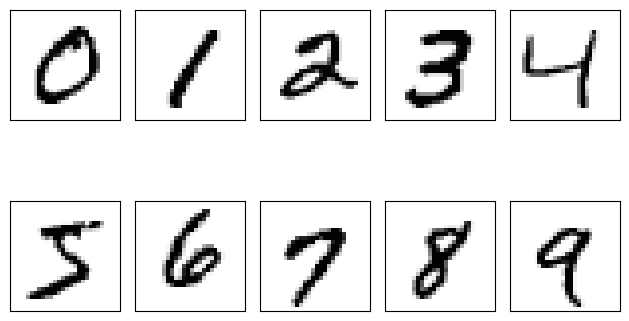

In [5]:
# MNIST에 있는 이미지 모습을 숫자 0에서 9 까지 샘플을 그림으로 출력해 보자
# 특성 행렬의 픽셀 벡터 784개를 원본 28 * 28 이미지로 크기를 변경한 후 matplotlib의 imshow함수로 그린다ㅣ
fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)
ax = ax.flatten()
for i in range(10):
  img = X[y == i][0].reshape(28,28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

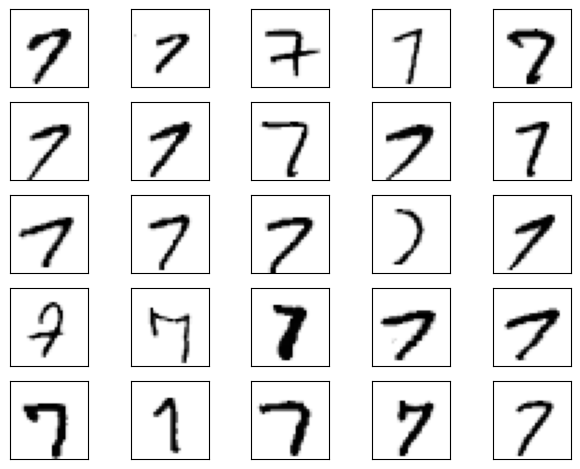

In [6]:
# 손글씨마다 얼마나 차이가 나는지 보기 위해 같은 숫자의 샘플을 여러 개 출력해 보자
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True)

ax = ax.flatten()
for i in range(25):
  img = X[y == 7][i].reshape(28,28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
# 데이터셋을 훈련, 검증, 테스트 subset으로 나누어 보자
# 5만 5000개의 이미지를 훈련에, 5000개의 이미지를 검증에, 10000개의 이미지를 테스트에 사용하도록 테스트셋을 분할함
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 1/7, random_state = 123, stratify = y # test_size = 100000으로 해도 됨
)

X_train, X_valid, y_train, y_valid =  train_test_split(
    X_train, y_train, test_size = 1/12, random_state = 123, stratify = y_train # test_size = 5000으로 해도 됨
)


In [8]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(55000, 784)
(5000, 784)
(10000, 784)


# 11.2.2 다층 퍼셉트론 구현
입력층, 은닉층, 출력층이 각각 하나씩 있는 MLP구현을 작성하고 MNIST 데이터셋의 이미지를 분류해 보자

In [9]:
# 먼저 로지스틱 시그모이드 활성화 함수를 계산하는 함수와 정수 클래스 레이블 배열을 원-핫 인코딩된 레이블로 변환하는 함수를 만들자
import numpy as np

def sigmoid(z):
  return 1./(1 + np.exp(-z))

def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels)) # 사실 num_labels = np.unique(y)로 해도 될 것 같지만, 안된다 왤까?
  for i, val in enumerate(y):
    ary[i, val] = 1
  return ary

In [10]:
# 다음으로 MLP의 메인 클래승인 NeuralNetMLP를 만들어 보자
# 이 클래스에는 3개의 클래스 메서드 .__init__(), .forward(), .backward()가 있음

class NeuralNetMLP:
  def __init__(self, num_features, num_hidden, num_classes, random_seed = 123):
    super().__init__()

    self.num_classes = num_classes

    # 은닉층
    rng = np.random.RandomState(random_seed)
    self.weight_h = rng.normal(loc = 0.0, scale = 0.1, size = (num_hidden, num_features))
    self.bias_h = np.zeros(num_hidden)

    # 출력층
    self.weight_out = rng.normal(loc = 0.0, scale = 0.1, size = (num_classes, num_hidden))
    self.bias_out = np.zeros(num_classes)

  def forward(self, x):
    # 시그모이드 함수 사용
    # 은닉층
    # 입력 차원 : [n_examples, n_features]
    #           dot [n_hidden, n_features].T
    # 출력 차원 : [n_examples, n_hidden]

    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # 출력층
    # 입력 차원 : [n_examples, n_hidden]
    #           dot [n_classes, n_hidden].T
    # 출력 차원 : [n_examples, n_classes]
    z_out = np.dot(a_h ,self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)
    return a_h, a_out

  # 신경망의 가중치와 절편 파라미터를 업데이트하는 backward 메서드에 대해 알아보자
  def backward(self, x, a_h, a_out, y):
    # loss function은 MSE손실사용

    ################################
    ### 출력층 가중치
    ################################
    # 원-핫 인코딩
    y_onehot = int_to_onehot(y, self.num_classes)

    # Part1 : dLoss/dOutWeights 를 구해보자
    dloss__da_out = 2.*(a_out - y_onehot) / y.shape[0]
    da_out__dz_out = a_out * (1. - a_out) # element-wise
    # 출력 차원 : [n_examples, n_classes]
    delta_out = dloss__da_out * da_out__dz_out # element-wise

    # W_out을 위한 그레디언트

    # [n_examples, n_hidden]
    dz_out__dw_out = a_h

    # 출력 차원 : [n_classes, n_hidden]
    dloss__dw_out = np.dot( delta_out.T, dz_out__dw_out)
    dloss__db_out = np.sum( delta_out, axis = 0)

    # Part2 : dLoss/dHiddenWeights 를 구해보자
    dz_out__da_h = self.weight_out
    dloss__da_h = np.dot(delta_out, dz_out__da_h)
    da_h__dz_h = a_h * (1. - a_h)
    dz_h__dw_h = x
    dloss__dw_h = np.dot( (dloss__da_h * da_h__dz_h).T, dz_h__dw_h)
    dloss__db_h = np.sum( dloss__da_h * da_h__dz_h ,axis = 0)
    return (dloss__dw_out, dloss__db_out, dloss__dw_h, dloss__db_h)


사이킷런은 .fit()과 .predict() 메서드를 중심으로 구현되지만, NeuralNetMLP클래스의 주요 메서드는 forward(), backward()임.  
그 이유 중 하나는 네트워크를 통해 정보가 흐르는 측면에서 복잡한 신경망을 조금 더 쉽게 이해할 수 있기 때문.  

또 다른 이유는 이 구현이 파이토치와 작동 방식이 비교적 유사하기 때문

In [11]:
# 새로운 NeuralNetMLP 클래스의 객체를 만들어보자
model = NeuralNetMLP (num_features = 28*28,
                      num_hidden = 50,
                      num_classes = 10)

# 11.2.3 신경망 훈련 루프 코딩
먼저 데이터 로딩을 위한 몇 가지 헬퍼 함수를 만들고, 이 함수들을 훈련 루프에 포함시켜 여러 에포크에 걸쳐 데이터셋을 반복해보자.

In [12]:
# 첫번째 헬퍼 함수, 미니 배치 생성기
import numpy as np
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, X.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx : start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

In [13]:
# 미니 배치 생성기가 잘 작동하는지 확인해보자
for i in range(num_epochs):
  minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [14]:
# 손실 함수와 성능지표
def mse_loss(targets, probas, num_labels = 10):
  onehot_targets = int_to_onehot(targets, num_labels = num_labels)
  return np.mean((onehot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
  return np.mean(targets == predicted_labels)

In [15]:
# 위의 함수들을 테스트하고 이전 절에서 만든 모델의 검증 세트 MSE와 정확도를 계산해보자
a_h, a_out = model.forward(X_valid)
mse = mse_loss(y_valid, a_out)
print(f'검증 세트 MSE: {mse:.1f}')
acc = accuracy(y_valid, np.argmax( a_out, axis = 1))
print(f'검증 세트 정확도: {acc*100:.1f}%')


검증 세트 MSE: 0.3
검증 세트 정확도: 9.8%


In [16]:
# 미니 배치 생성기를 사용하여 MSE의 정확도를 계산해 보자
def compute_mse_and_acc(nnet, X, y, num_labels = 10, minibatch_size = 100):
  mse, correct_pred, num_examples = 0., 0, 0
  minibatch_gen = minibatch_generator(X,y,minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    a_h, a_out = nnet.forward(features)
    predicted_labels = np.argmax(a_out, axis = 1)
    onehot_targets = int_to_onehot(targets, num_labels = num_labels)
    loss = np.mean(( a_out - onehot_targets )**2)
    correct_pred += np.sum( predicted_labels == targets )
    num_examples += targets.shape[0]
    mse += loss
  mse = mse / i # 이부분이 되게 특이하므로 기억해두자!
  acc = correct_pred / num_examples
  return mse, acc

In [17]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'검증 세트 MSE : {mse:.1f}')
print(f'검증 세트 정확도 : {acc*100:.1f}%')

검증 세트 MSE : 0.3
검증 세트 정확도 : 9.8%


In [18]:
# 이제 모델 훈련을 위한 코드를 구현해 보자
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate = 0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []
  for e in range(num_epochs):
    # 미니 배치를 반복함
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for features, targets in minibatch_gen:
      # forward pass
      a_h, a_out = model.forward(features)

      # backward pass
      dloss__dw_out, dloss__db_out, \
      dloss__dw_h, dloss__db_h = \
          model.backward(features, a_h, a_out, targets)

      # weights update
      model.weight_h -= learning_rate * dloss__dw_h
      model.bias_h -= learning_rate * dloss__db_h
      model.weight_out -= learning_rate * dloss__dw_out
      model.bias_out -= learning_rate * dloss__db_out

    # epoch 로그
    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
    train_acc, valid_acc = train_acc*100, valid_acc*100
    epoch_loss.append(train_mse);
    epoch_train_acc.append(train_acc);
    epoch_valid_acc.append(valid_acc);
    print(f'에포크 : {e+1:03d}/{num_epochs:03d} '
          f'| 훈련 MSE: {train_mse:.2f} '
          f'| 훈련 정확도: {train_acc:.2f}% '
          f'| 검증 정확도: {valid_acc:.2f} % ')
  return epoch_loss, epoch_train_acc, epoch_valid_acc


In [19]:
# 에포크 50번으로 해서 훈련시켜 보자
np.random.seed(123) # 훈련 세트 셔플링을 위해
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs = 50, learning_rate = 0.1
)

에포크 : 001/050 | 훈련 MSE: 0.05 | 훈련 정확도: 77.94% | 검증 정확도: 77.60 % 
에포크 : 002/050 | 훈련 MSE: 0.03 | 훈련 정확도: 86.24% | 검증 정확도: 85.76 % 
에포크 : 003/050 | 훈련 MSE: 0.02 | 훈련 정확도: 88.47% | 검증 정확도: 88.24 % 
에포크 : 004/050 | 훈련 MSE: 0.02 | 훈련 정확도: 89.83% | 검증 정확도: 89.58 % 
에포크 : 005/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.59% | 검증 정확도: 90.32 % 
에포크 : 006/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.00% | 검증 정확도: 90.78 % 
에포크 : 007/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.46% | 검증 정확도: 91.10 % 
에포크 : 008/050 | 훈련 MSE: 0.01 | 훈련 정확도: 91.73% | 검증 정확도: 91.36 % 
에포크 : 009/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.16% | 검증 정확도: 91.84 % 
에포크 : 010/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.36% | 검증 정확도: 92.12 % 
에포크 : 011/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.61% | 검증 정확도: 92.50 % 
에포크 : 012/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.80% | 검증 정확도: 92.56 % 
에포크 : 013/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.96% | 검증 정확도: 92.64 % 
에포크 : 014/050 | 훈련 MSE: 0.01 | 훈련 정확도: 93.11% | 검증 정확도: 92.94 % 
에포크 : 015/050 | 훈련 MSE: 0.01 | 훈련 정확도: 93.30% | 검증 정확도: 93.24 % 
에포크 : 016/050 | 훈련 MSE: 0

# 11.2.4 신경망 모델의 성능 평가
train() 함수에서 수집한 각 에포크마다의 훈련 손실과 훈련 및 검증 정확도를 맷플롯립을 사용해서 시각화 할 수 있음.


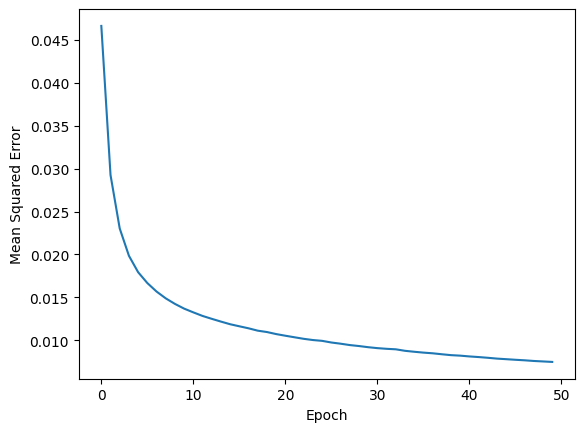

In [20]:
# 먼저 MSE손실을 살펴보자
plt.plot(range(len(epoch_loss)),epoch_loss) # 그냥 plt.plt(epoch_loss) 해도 됨
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

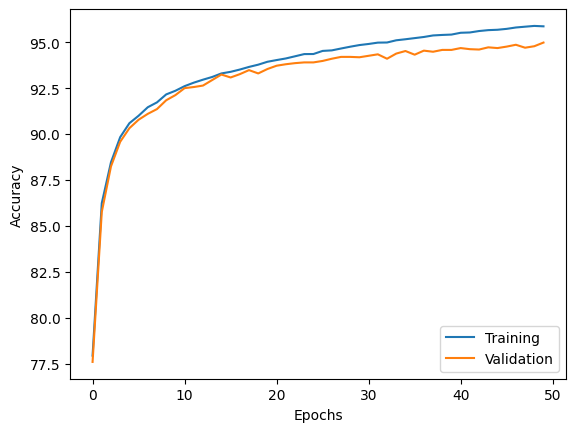

In [24]:
# 이제 훈련 정확도와 검증 정확도를 살펴보자
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label = 'Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()


In [33]:
# 마지막으로 테스트 데이터셋에서 예측 정확도를 계산하여 모델 일반화 성능을 평가해 보자
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test) # 사실 test때는 datagenerator가 필요없지만, 귀찮으니.. 걍
print(f'테스트 정확도 : {test_acc*100:.2f}%')

테스트 정확도 : 94.74%


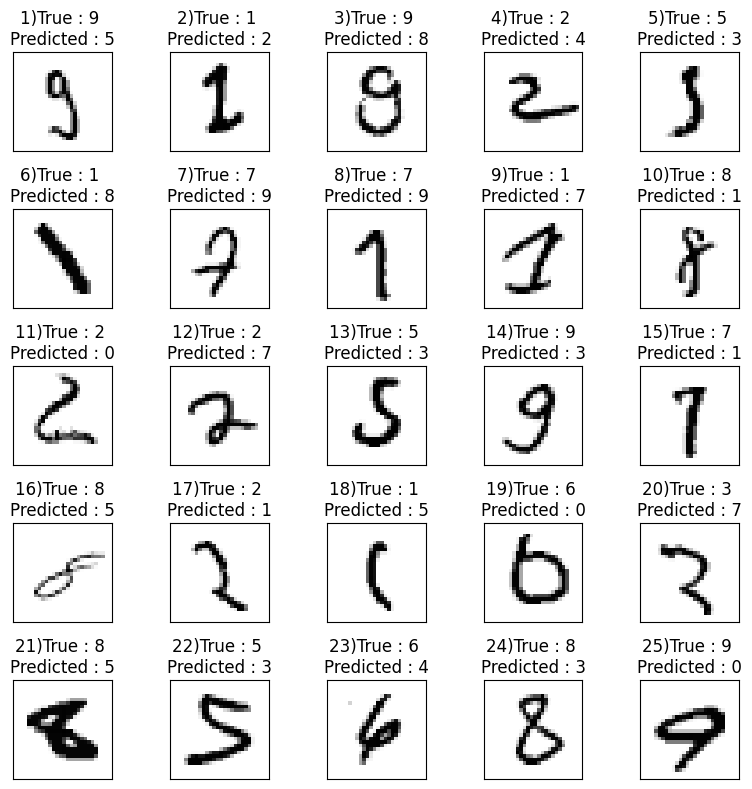

In [32]:
# 마지막으로 이 MLP가 어떤 샘플에서 어려움을 겪고 있는지 알아보기 위해
# 테스트 세트에서 잘못 분류된 처음 25개의 샘플을 확인해 보자
X_test_subset = X[:1000,:]
y_test_subset = y[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis = 1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig,ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (8,8))

ax = ax.flatten()
for i in range(25):
  img = misclassified_images[i].reshape(28,28)
  ax[i].imshow(img, cmap = 'Greys', interpolation = 'nearest')
  ax[i].set_title(f'{i+1})'
                  f'True : {correct_labels[i]} \n'
                  f'Predicted : {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()